In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymcr
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
from pymcr.mcr import McrAR
import pyro
from sklearn.decomposition import PCA
import torch
import torchinfo
from pyro.infer import Predictive

from pymcr_torch_demo import pyro_model as pm


print("Python version: ", sys.version)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("pymcr version: ", pymcr.__version__)
print("torch version", torch.__version__)

/Users/brandonsaint-john/src/pymcr-torch-demo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version:  3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
numpy version:  2.1.3
matplotlib version:  3.9.2
pymcr version:  0.5.1
torch version 2.5.1


In [3]:
random.seed(717)
np.random.seed(717)
torch.manual_seed(717)

In [4]:
torchinfo.summary(
    pm.Encoder(input_size=2301, hidden_size=256, z_dim=64), (1, 2301)
)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 64]                   --
├─Linear: 1-1                            [1, 256]                  589,312
├─ReLU: 1-2                              [1, 256]                  --
├─Linear: 1-3                            [1, 64]                   16,448
├─Linear: 1-4                            [1, 64]                   16,448
Total params: 622,208
Trainable params: 622,208
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.62
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.49
Estimated Total Size (MB): 2.50

In [5]:
torchinfo.summary(pm.Decoder(output_size=2301, hidden_size=256, z_dim=64), (1, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 2301]                 --
├─Linear: 1-1                            [1, 256]                  16,640
├─ReLU: 1-2                              [1, 256]                  --
├─Linear: 1-3                            [1, 2301]                 591,357
Total params: 607,997
Trainable params: 607,997
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.61
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.43
Estimated Total Size (MB): 2.45

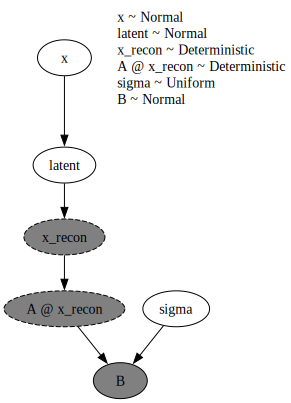

In [6]:
pyro.render_model(
    pm.VAE(input_size=2301, hidden_size=256, z_dim=64).model,
    model_args=(torch.ones(55, 2), torch.ones(55, 2301)),
    render_deterministic=True,
    render_distributions=True,
)

In [7]:
with open("../data/ethanol/ethanol-mcr.npz", "rb") as ethanol_mcr_file:
    ethanol_mcr = np.load(ethanol_mcr_file)

    D = ethanol_mcr["D"]
    C = ethanol_mcr["C"]
    St = ethanol_mcr["ST"]
    wavelengths = ethanol_mcr["wavelengths"]

    N_SAMPLES = D.shape[0]
    N_WAVELENGTHS = D.shape[1]
    N_COMPONENTS = C.shape[1]

    print(ethanol_mcr)

NpzFile 'object' with keys: D, C, ST, wavelengths


In [8]:
print(
    f"D shape (samples x wavelengths): {D.shape}\n"
    f"C shape (samples x components): {C.shape}\n"
    f"ST shape (components x wavelengths): {St.shape}\n"
    f"wavelengths shape: {wavelengths.shape}"
)

D shape (samples x wavelengths): (55, 2301)
C shape (samples x components): (55, 2)
ST shape (components x wavelengths): (2, 2301)
wavelengths shape: (2301,)


## Predicting Concentrations from Pure Spectra

The fit errors due to the mean-squared error increasing above the tolerance. From what I understand, this means it finds the optimal value very quickly.

In [9]:
mcrar_conc = McrAR(
    max_iter=100,
    st_regr=pm.McrVae(input_size=N_WAVELENGTHS, hidden_size=256, z_dim=64),
    c_regr="OLS",
    c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=1.0,
)
mcrar_conc.fit(D=D, ST=St, verbose=True)

Iter: 1 (C)	mse: 2.9061e-04
epoch loss 283105388.3315363
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 1 (ST)	mse: 4.6236e-04
Iter: 2 (C)	mse: 4.6103e-04
epoch loss 276386698.6910999
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 2 (ST)	mse: 3.9239e-04
Iter: 3 (C)	mse: 3.9017e-04
epoch loss 268922591.9961277
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 3 (ST)	mse: 3.3620e-04
Iter: 4 (C)	mse: 3.3502e-04
epoch loss 262522373.5850985
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 4 (ST)	mse: 2.6827e-04
Iter: 5 (C)	mse: 2.6062e-04
epoch loss 255394825.17570245
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 5 (ST)	mse: 2.9367e-04
Iter: 6 (C)	mse: 2.9805e-04
epoch loss 248588565.99456334
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 6 (ST)	mse: 2.3285e-04
Iter: 7 (C)	mse: 2.3096e-04
epoch loss 241691805.41459525
A, B shape =  torch.Size([55, 2]) torch.Size([55, 2301])
Iter: 7 (ST)	mse: 2.2360e

In [10]:
def plot_mcrar_concentrations(mcr_obj: McrAR):
    fig, ax = plt.subplots(1, 1)
    mcr_obj.fit(D=D, ST=St, verbose=True)
    ax.scatter(x=C[:, 0], y=mcr_obj.C_opt_[:, 1], s=10, alpha=0.5)
    plt.ylabel("Predictions from MCR-ALS")
    plt.xlabel("Ground Truth Ethanol Percentages")
    plt.title("MCR-ALS Predictions based on Pure Spectra")
    return fig, ax


def plot_mcrar_spectra(mcr_obj, ax = None):
    mcr_obj.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)
    vis_cols = [
        float(col.split("_")[1]) for col in wavelengths if "avaspec" in col
    ]
    nir_cols = [
        float(col.split("_")[1]) for col in wavelengths if "hamamatsu" in col
    ]

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

    ax[0].plot(
        vis_cols,
        mcr_obj.ST_[0, :2048],
        alpha=0.4,
    )
    ax[0].plot(
        vis_cols,
        mcr_obj.ST_[1, :2048],
        alpha=0.4,
    )

    ax[1].plot(
        nir_cols,
        mcr_obj.ST_[0, 2048:],
        alpha=0.4,
    )
    ax[1].plot(
        nir_cols,
        mcr_obj.ST_[1, 2048:],
        alpha=0.4,
    )

    ax[1].set_title("NIR Predicted Pure Spectra")
    ax[0].set_title("Visible Predicted Pure Spectra")
    ax[0].set_ylabel("Predicted Absorbance")
    ax[0].set_xlabel("Wavelength (nm)")
    ax[1].set_xlabel("Wavelength (nm)")
    return fig, ax

Text(0.5, 1.0, 'MCR-ALS Predictions based on Pure Spectra')

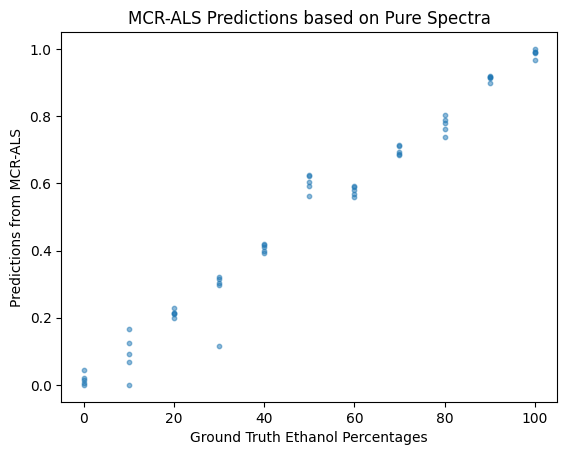

In [11]:
# I think its random whjch axis in C_opt_ gets which concentration
plt.scatter(x=C[:, 0], y=mcrar_conc.C_opt_[:, 1], s=10, alpha=0.5)
plt.ylabel("Predictions from MCR-ALS")
plt.xlabel("Ground Truth Ethanol Percentages")
plt.title("MCR-ALS Predictions based on Pure Spectra")

## Predicting Pure Spectra from Concentration data

In this example I leave out the pure water and ethanol spectra that we already know. In the data matrix, these are the first 5 and last 5 samples. The 

In [12]:
mcrar_spec = McrAR(
    max_iter=100,
    st_regr=pm.McrVae(input_size=N_WAVELENGTHS, hidden_size=256, z_dim=64),
    c_regr="OLS",
    # c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
)
mcrar_spec.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)

epoch loss 300858617.0277389
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 1 (ST)	mse: 5.0913e-04
Iter: 2 (C)	mse: 4.7229e-04
epoch loss 296727840.6654285
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 2 (ST)	mse: 4.1602e-04
Iter: 3 (C)	mse: 2.8509e-04
epoch loss 293037538.2822758
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 3 (ST)	mse: 2.5582e-04
Iter: 4 (C)	mse: 2.4999e-04
epoch loss 288462222.75652444
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 4 (ST)	mse: 2.6705e-04
Iter: 5 (C)	mse: 2.3907e-04
epoch loss 284061954.8076545
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 5 (ST)	mse: 2.0971e-04
Iter: 6 (C)	mse: 2.0203e-04
epoch loss 279297200.9022163
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 6 (ST)	mse: 2.2856e-04
Iter: 7 (C)	mse: 2.0054e-04
epoch loss 274476663.7508961
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 7 (ST)	mse: 2.0838e-04
Iter: 8 (C)	mse: 1.6274e-0

Text(0.5, 0, 'Wavelength (nm)')

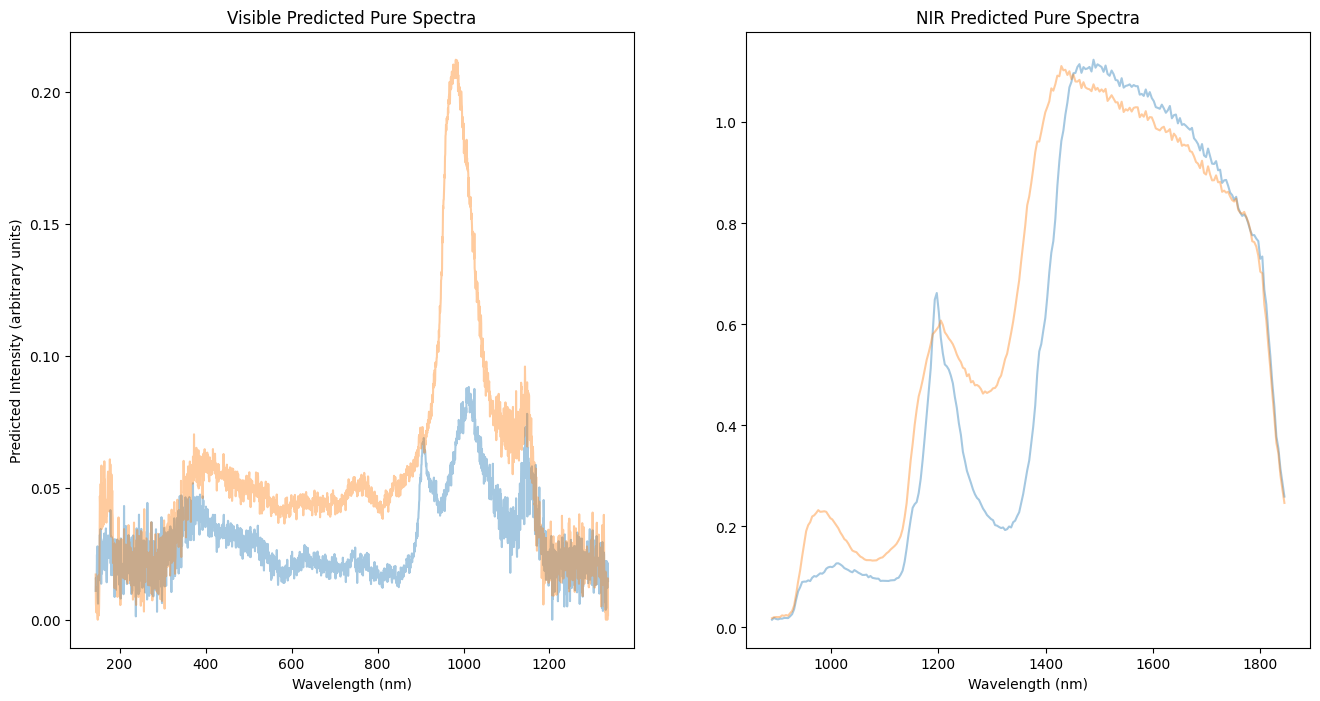

In [13]:
vis_cols = [
    float(col.split("_")[1]) for col in wavelengths if "avaspec" in col
]
nir_cols = [
    float(col.split("_")[1]) for col in wavelengths if "hamamatsu" in col
]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].plot(
    vis_cols,
    mcrar_spec.ST_[0, :2048],
    alpha=0.4,
)
ax[0].plot(
    vis_cols,
    mcrar_spec.ST_[1, :2048],
    alpha=0.4,
)

ax[1].plot(
    nir_cols,
    mcrar_spec.ST_[0, 2048:],
    alpha=0.4,
)
ax[1].plot(
    nir_cols,
    mcrar_spec.ST_[1, 2048:],
    alpha=0.4,
)

ax[1].set_title("NIR Predicted Pure Spectra")
ax[0].set_title("Visible Predicted Pure Spectra")
ax[0].set_ylabel("Predicted Intensity (arbitrary units)")
ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")

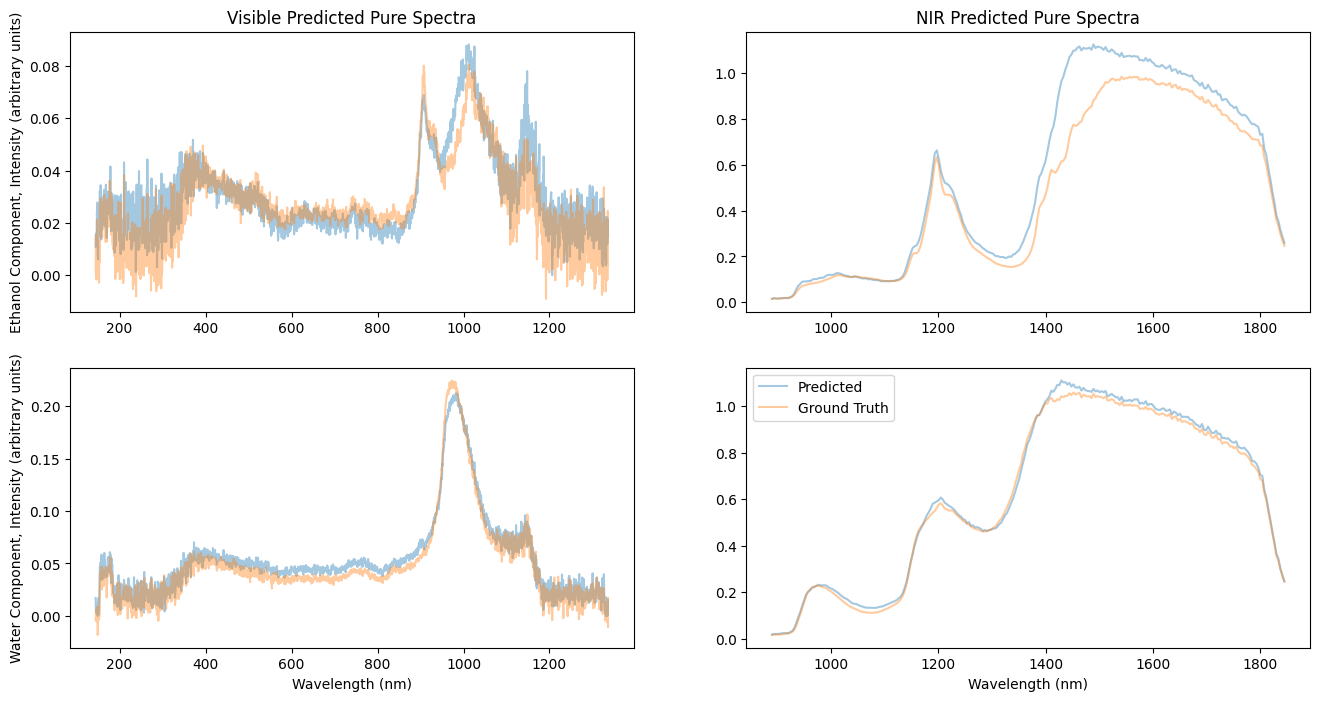

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

ax[0, 0].plot(
    vis_cols,
    mcrar_spec.ST_[0, :2048],
    alpha=0.4,
)
ax[0, 0].plot(
    vis_cols,
    St[1, :2048],
    alpha=0.4,
    
)
ax[1, 0].plot(
    vis_cols,
    mcrar_spec.ST_[1, :2048],
    alpha=0.4,
)
ax[1, 0].plot(
    vis_cols,
    St[0, :2048],
    alpha=0.4,
    
)

ax[0, 1].plot(
    nir_cols,
    mcrar_spec.ST_[0, 2048:],
    alpha=0.4,
    label="Prediction"
)
ax[0, 1].plot(
    nir_cols,
    St[1, 2048:],
    alpha=0.4,
    label="Ground Truth"
)

ax[1, 1].plot(
    nir_cols,
    mcrar_spec.ST_[1, 2048:],
    alpha=0.4,
    label="Predicted",
)
ax[1, 1].plot(
    nir_cols,
    St[0, 2048:],
    alpha=0.4,
    label="Ground Truth",
)

ax[0, 1].set_title("NIR Predicted Pure Spectra")
ax[0, 0].set_title("Visible Predicted Pure Spectra")
ax[0, 0].set_ylabel("Ethanol Component, Intensity (arbitrary units)")
ax[1, 0].set_ylabel("Water Component, Intensity (arbitrary units)")
ax[-1, 0].set_xlabel("Wavelength (nm)")
ax[-1, 1].set_xlabel("Wavelength (nm)")
ax[-1, -1].legend()

(2, 2301)
(55, 2301)


Text(0.5, 0.98, 'Sampling latent variables of pure spectra')

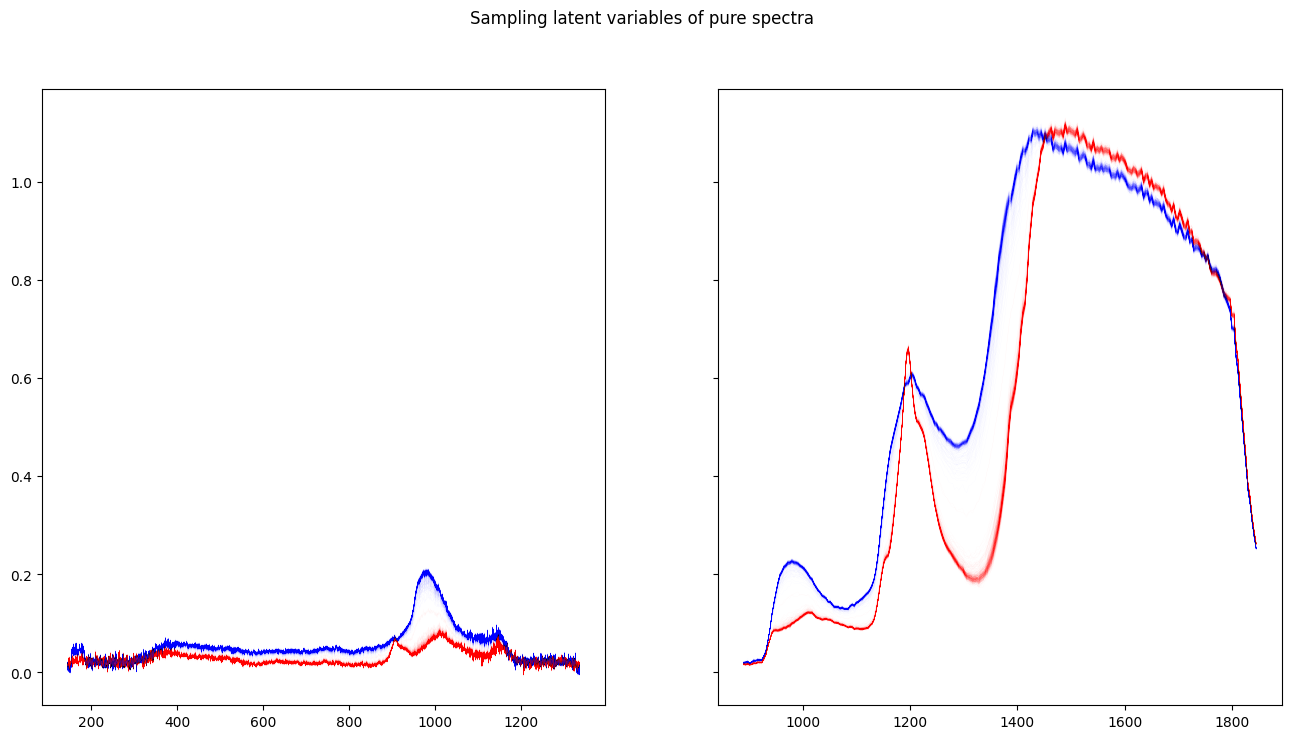

In [15]:
plot_params = {
    "alpha": 0.05,
    "lw": 0.1,
}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)
print(St.shape)
print(D.shape)
for _ in range(500):
# D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True
    z = mcrar_spec.st_regressor.guide(C[5:-5, :], D[5:-5, :])
    spectra = mcrar_spec.st_regressor.vae.decoder(z["latent"])
    spectra = spectra.detach().numpy()
    ax[0].plot(
        vis_cols,
        spectra[1, :2048],
        c="blue",
        **plot_params
    )
    ax[0].plot(
        vis_cols,
        spectra[0, :2048],
        c="red",
        **plot_params
    )
    # plot_params["alpha"] = min(1.0, plot_params["alpha"] *  2)
    # plot_params["lw"] *= 2
    ax[1].plot(
        nir_cols,
        spectra[1, 2048:],
        c="blue",
        **plot_params
    )
    ax[1].plot(
        nir_cols,
        spectra[0, 2048:],
        c="red",
        **plot_params
    )
fig.suptitle("Sampling latent variables of pure spectra")

In [16]:

num_samples = 100
predictive = Predictive(
    model=mcrar_spec.st_regressor.vae.model, guide=mcrar_spec.st_regressor.guide, num_samples=num_samples
)
pred = predictive(torch.from_numpy(C[5:-5, :]).float(), torch.from_numpy(D[5:-5, :]).float())
pred
# mcrar.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)

{'x': tensor([[[ 0.5601,  0.7918, -0.6568,  ..., -0.8529,  1.3761, -0.8868],
          [ 0.2518, -0.7600, -1.3436,  ..., -0.0382, -0.2312, -0.2953]],
 
         [[ 0.8384, -0.3405, -0.9730,  ..., -0.4728,  0.7920,  1.1356],
          [-0.4641,  0.7045,  0.9910,  ..., -0.6495,  0.8218, -0.2592]],
 
         [[-0.8350, -0.5779, -1.8754,  ...,  0.1551, -0.2820,  0.6342],
          [ 0.1897,  0.3176, -0.3253,  ...,  0.8734, -0.0883,  0.2381]],
 
         ...,
 
         [[-1.3728, -0.0964, -0.6417,  ..., -0.0275, -0.0354, -0.6327],
          [ 2.0907, -0.7001,  0.1414,  ...,  0.5537,  0.0837, -0.2383]],
 
         [[ 0.3230,  0.0557,  0.4500,  ...,  1.2585, -0.0899,  0.8514],
          [-2.2552,  0.7348,  1.0714,  ...,  0.7805,  0.0579, -0.0425]],
 
         [[-0.1535,  1.2015, -0.2879,  ...,  0.0257, -0.0790, -0.5958],
          [ 0.9755,  0.0346,  0.5146,  ...,  0.5501,  0.1527, -1.8826]]]),
 'latent': tensor([[[ 4.1665e-01, -1.1955e-01,  1.0148e-01,  ...,  1.6021e-01,
            3.5661

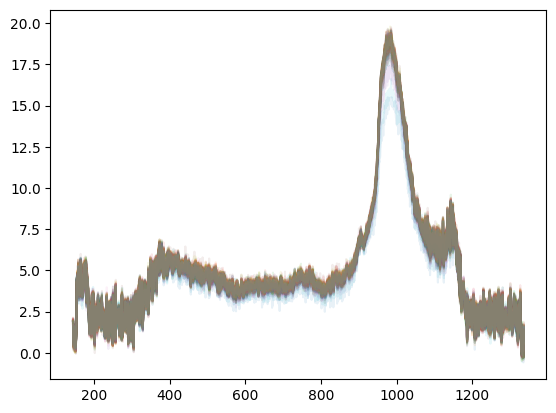

In [17]:
plt.plot(vis_cols, pred["A @ x_recon"][:, 1, :2048].T, alpha=0.1)

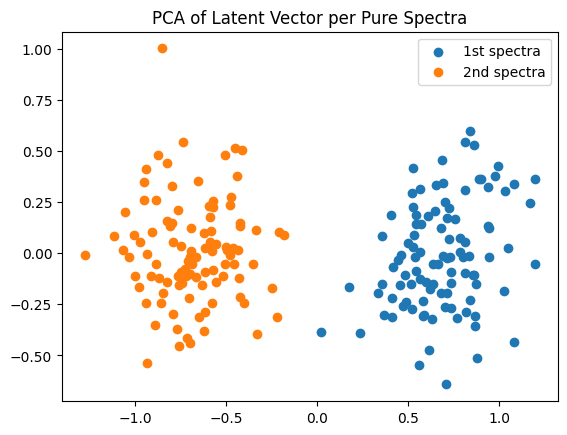

In [18]:
from sklearn.decomposition import PCA
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)
z_loc, z_scale = mcrar_spec.st_regressor.vae.encoder(torch.from_numpy(St.astype(np.float32)))
fst_samples = []
snd_samples = []
for _ in range(100):
    # z = dist.Normal(z_loc, z_scale).sample()
    # sample = mcrar.st_regressor.vae.decoder(z).detach().numpy()
    z = mcrar_spec.st_regressor.guide(St, D)["latent"].detach().numpy()
    # spectra = mcrar.st_regressor.vae.decoder(z)
    # spectra = spectra.detach().numpy()
    fst_samples.append(z[0, :])
    snd_samples.append(z[1, :])
samples = np.vstack((fst_samples, snd_samples))
# print(samples.shape)

pca = PCA(n_components=2)
res = pca.fit_transform(samples)
plt.scatter(res[:len(fst_samples), 0], res[:len(fst_samples), 1], label="1st spectra")
plt.scatter(res[len(fst_samples):, 0], res[len(fst_samples):, 1], label="2nd spectra")
plt.title("PCA of Latent Vector per Pure Spectra")
plt.legend()

epoch loss 306052415.6996735
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 1 (ST)	mse: 1.5645e-02
Iter: 2 (C)	mse: 1.1638e-02
epoch loss 302438270.3880547
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 2 (ST)	mse: 1.4814e-03
Iter: 3 (C)	mse: 1.0791e-03
epoch loss 298728025.3213763
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 3 (ST)	mse: 1.4695e-03
Iter: 4 (C)	mse: 1.3737e-03
epoch loss 294726484.48746
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 4 (ST)	mse: 5.9399e-04
Iter: 5 (C)	mse: 5.9190e-04
epoch loss 290557013.1507045
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 5 (ST)	mse: 7.7509e-04
Iter: 6 (C)	mse: 6.9366e-04
epoch loss 286151087.03972566
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 6 (ST)	mse: 6.3654e-04
Iter: 7 (C)	mse: 5.2233e-04
epoch loss 281403181.5641032
A, B shape =  torch.Size([45, 2]) torch.Size([45, 2301])
Iter: 7 (ST)	mse: 5.4656e-04
Iter: 8 (C)	mse: 3.9978e-04


(<Figure size 1600x800 with 2 Axes>,
 array([<Axes: title={'center': 'Visible Predicted Pure Spectra'}, xlabel='Wavelength (nm)', ylabel='Predicted Absorbance'>,
        <Axes: title={'center': 'NIR Predicted Pure Spectra'}, xlabel='Wavelength (nm)'>],
       dtype=object))

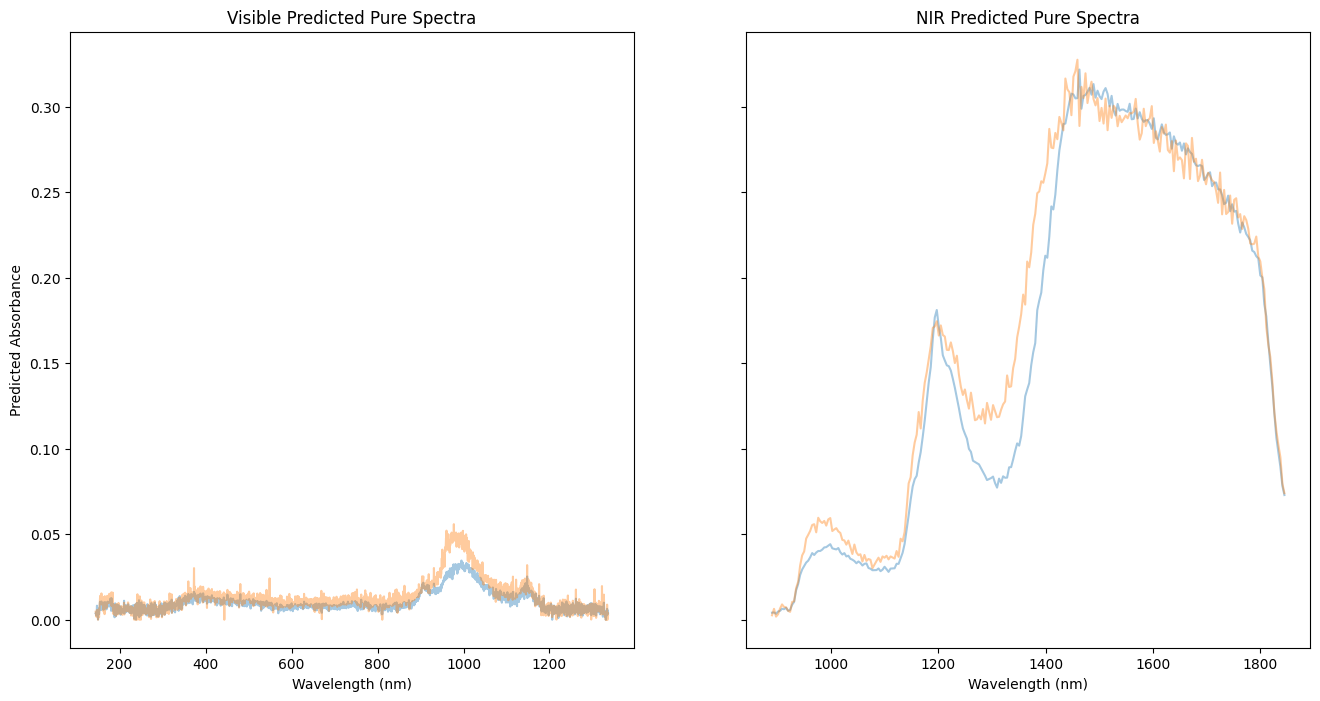

In [19]:
plot_mcrar_spectra(mcr_obj=McrAR(
    max_iter=100,
    st_regr=pm.McrVae(input_size=N_WAVELENGTHS, hidden_size=16, z_dim=4),
    c_regr="OLS",
    # c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
))

In [20]:
with open("../data/ethanol/lsq.npz", "rb") as lsq_file:
    lst_output = np.load(lsq_file)
    lsq_res = lst_output["lsq_st"]

Text(0.5, 0, 'Wavelength (nm)')

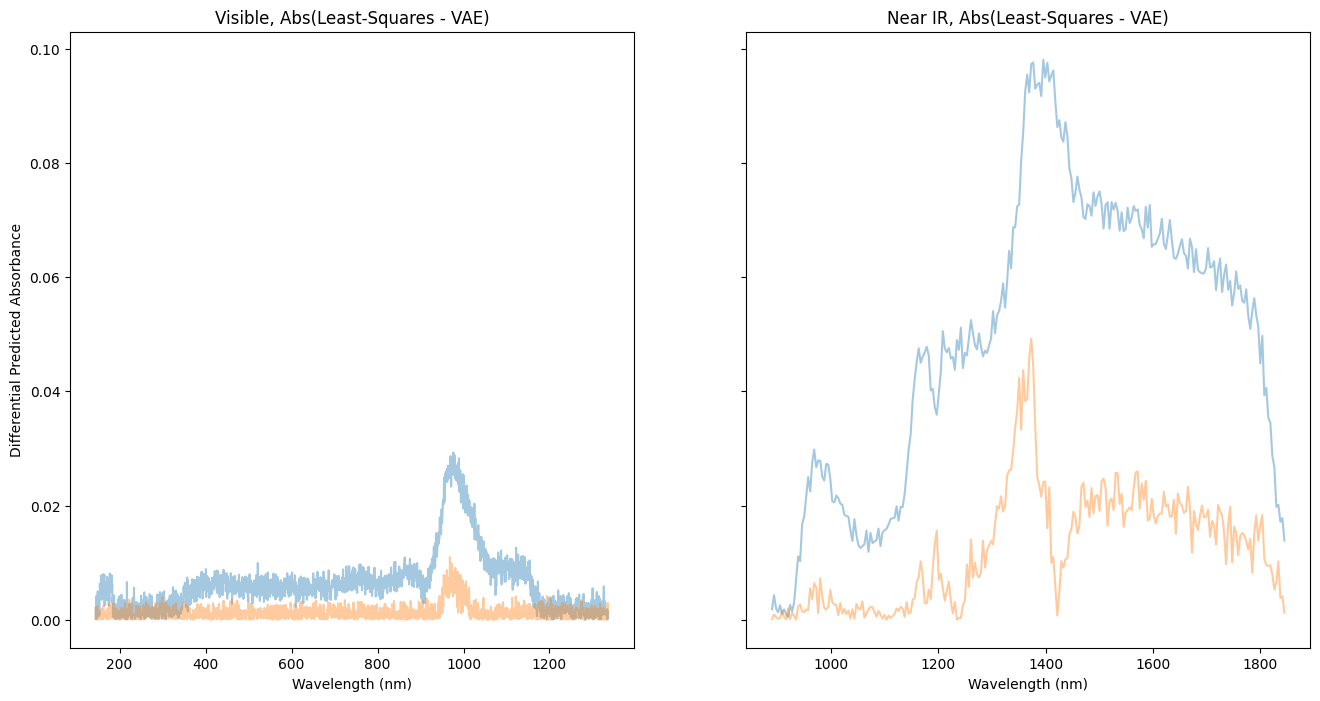

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

ax[0].plot(
    vis_cols,
    abs(mcrar_spec.ST_[0, :2048] - lsq_res[0, :2048]),
    alpha=0.4,
)
ax[0].plot(
    vis_cols,
    abs(mcrar_spec.ST_[1, :2048] - lsq_res[1, :2048]),
    alpha=0.4,
)

ax[1].plot(
    nir_cols,
    abs(mcrar_spec.ST_[0, 2048:] - lsq_res[0, 2048:]),
    alpha=0.4,
)
ax[1].plot(
    nir_cols,
    abs(mcrar_spec.ST_[1, 2048:] - lsq_res[1, 2048:]),
    alpha=0.4,
)

ax[1].set_title("Near IR, Abs(Least-Squares - VAE)")
ax[0].set_title("Visible, Abs(Least-Squares - VAE)")
ax[0].set_ylabel("Differential Predicted Absorbance")
ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")